In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import math
#from statsmodels.tsa.seasonal import seasonal_decompose
#from pandas import Series
#from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv("D:\ML_Stock_Forecast\Walmart.csv",parse_dates=['Date'])
datastores = pd.read_csv("D:\ML_Stock_Forecast\WalmartStores.csv")
#data = pd.read_csv("E:\Walmart\Walmart.csv",parse_dates=['Date'])
#datastores = pd.read_csv("E:\Walmart\WalmartStores.csv")

In [3]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
datastores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
datastores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [6]:
#Merge Sales and Store data
Salesdata = pd.merge(data,datastores, on = 'Store', how = 'left')

In [7]:
Salesdata.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [8]:
Salesdata.describe()

,Store,Dept,Weekly_Sales,Size
count,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739
std,12.785297,30.492054,22711.183519,60980.583328
min,1.000000,1.000000,-4988.940000,34875.000000
25%,11.000000,18.000000,2079.650000,93638.000000
50%,22.000000,37.000000,7612.030000,140167.000000
75%,33.000000,74.000000,20205.852500,202505.000000
max,45.000000,99.000000,693099.360000,219622.000000


In [9]:
# We can see negative Sales
Salesdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 7 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 22.9+ MB


In [10]:
# Check Null values
Salesdata.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
dtype: int64

In [11]:
Salesdata.IsHoliday.value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

In [12]:
Salesdata.Type.value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [13]:
# Dummy variable creation for categorical columns
walmartdata=pd.get_dummies(Salesdata,columns = ['IsHoliday','Type'])

In [14]:
#Verify if Dummy varaiables are created
walmartdata.head()

,Store,Dept,Date,Weekly_Sales,Size,IsHoliday_False,IsHoliday_True,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,151315,1,0,1,0,0
1,1,1,2010-02-12,46039.49,151315,0,1,1,0,0
2,1,1,2010-02-19,41595.55,151315,1,0,1,0,0
3,1,1,2010-02-26,19403.54,151315,1,0,1,0,0
4,1,1,2010-03-05,21827.90,151315,1,0,1,0,0


In [15]:
# Check correlation between varaibles
Salesdata.IsHoliday=Salesdata.IsHoliday.apply(lambda x: int(x)) 
df_str_type={'A':1,'B':2,'C':3} 
Salesdata['Type']=Salesdata['Type'].map(df_str_type)

In [16]:
Salesdata.corr(method ='kendall') 

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size
Store,1.000000,0.009812,-0.068593,-0.000451,0.114958,-0.115744
Dept,0.009812,1.000000,-0.020025,0.000664,-0.008585,0.007606
Weekly_Sales,-0.068593,-0.020025,1.000000,0.004591,-0.180432,0.198256
IsHoliday,-0.000451,0.000664,0.004591,1.000000,-0.000656,0.000469
Type,0.114958,-0.008585,-0.180432,-0.000656,1.000000,-0.681443
Size,-0.115744,0.007606,0.198256,0.000469,-0.681443,1.000000


In [17]:
#Remove negative Sales

# Get names of indexes for which column Weekly_Sales < 0 (-ve Sales)
indexNames = walmartdata[ walmartdata['Weekly_Sales'] < 0 ].index
 # Delete these row indexes from dataFrame
walmartdata.drop(indexNames , inplace=True)
walmartdata.describe() #Cehck min value for Weekly_sales if it is -ve

,Store,Dept,Weekly_Sales,Size,IsHoliday_False,IsHoliday_True,Type_A,Type_B,Type_C
count,420285.000000,420285.000000,420285.000000,420285.000000,420285.00000,420285.00000,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,16030.329773,136749.569176,0.92966,0.07034,0.511541,0.387401,0.101058
std,12.787213,30.507197,22728.500149,60992.688568,0.25572,0.25572,0.499867,0.487157,0.301405
min,1.000000,1.000000,0.000000,34875.000000,0.00000,0.00000,0.000000,0.000000,0.000000
25%,11.000000,18.000000,2117.560000,93638.000000,1.00000,0.00000,0.000000,0.000000,0.000000
50%,22.000000,37.000000,7659.090000,140167.000000,1.00000,0.00000,1.000000,0.000000,0.000000
75%,33.000000,74.000000,20268.380000,202505.000000,1.00000,0.00000,1.000000,1.000000,0.000000
max,45.000000,99.000000,693099.360000,219622.000000,1.00000,1.00000,1.000000,1.000000,1.000000


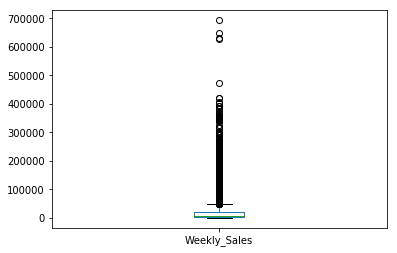

In [18]:
# Check Outliers for Weekly Sales
walmartdata.Weekly_Sales.plot(kind='box')

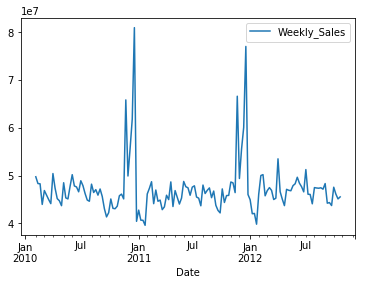

In [19]:
# date vs sales to see the behaviour of Outliers
WeeklySales = walmartdata[['Date','Weekly_Sales']].groupby('Date').sum()
WeeklySales.plot()

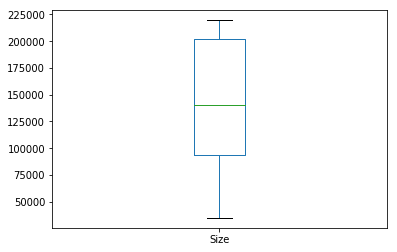

In [20]:
# Check the outliers for other continuous variables
walmartdata.Size.plot(kind='box')

In [21]:
#walmartdata.plot.scatter(x='Type',y='Size',color ='c',title = 'scatter Plot : Type vs. Size')
walmartdata.groupby(['Type_A','Type_B','Type_C'])['Weekly_Sales'].sum()

Type_A  Type_B  Type_C
0       0       1         4.055080e+08
        1       0         2.000742e+09
1       0       0         4.331057e+09
Name: Weekly_Sales, dtype: float64

In [22]:
#walmartdata['Year'] = pd.DatetimeIndex(walmartdata['Date']).year 
#walmartdata['Month'] = pd.DatetimeIndex(walmartdata['Date']).month 
#walmartdata['Day'] = pd.DatetimeIndex(walmartdata['Date']).day  

In [23]:
#walmartdata.plot.scatter(x='Type_A',y='Weekly_Sales',color ='c',title = 'Scatter Plot : Sales vs. Type')
#Verify if date has been set as index
walmartdata.head()

,Store,Dept,Date,Weekly_Sales,Size,IsHoliday_False,IsHoliday_True,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,151315,1,0,1,0,0
1,1,1,2010-02-12,46039.49,151315,0,1,1,0,0
2,1,1,2010-02-19,41595.55,151315,1,0,1,0,0
3,1,1,2010-02-26,19403.54,151315,1,0,1,0,0
4,1,1,2010-03-05,21827.90,151315,1,0,1,0,0


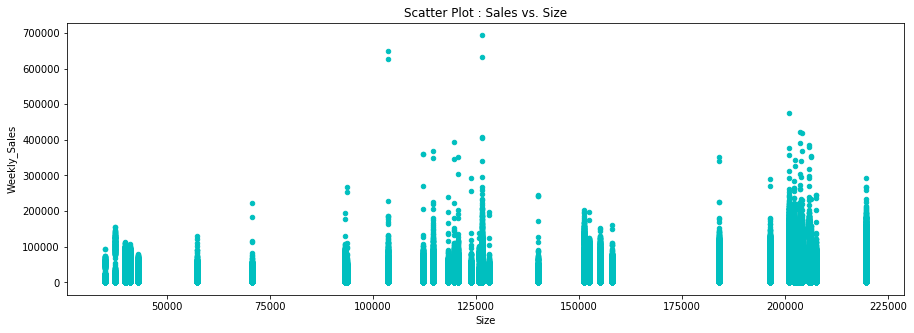

In [24]:
#pd.crosstab(walmartdata.Store,walmartdata.Size)
walmartdata.plot.scatter(x='Size',y='Weekly_Sales',color ='c',title = 'Scatter Plot : Sales vs. Size',figsize = (15,5))

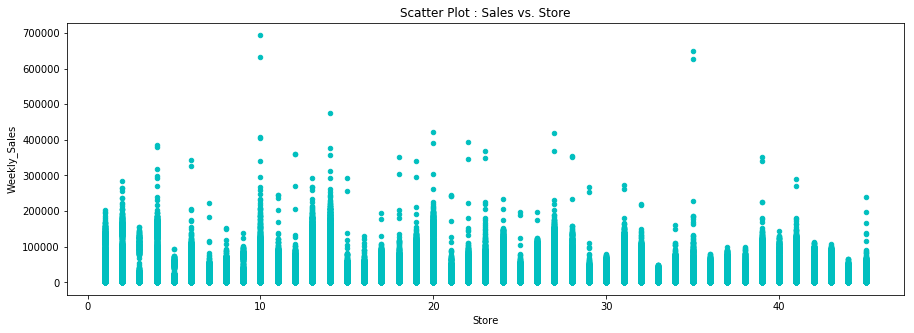

In [25]:
walmartdata.plot.scatter(x='Store',y='Weekly_Sales',color ='c',title = 'Scatter Plot : Sales vs. Store',figsize = (15,5))

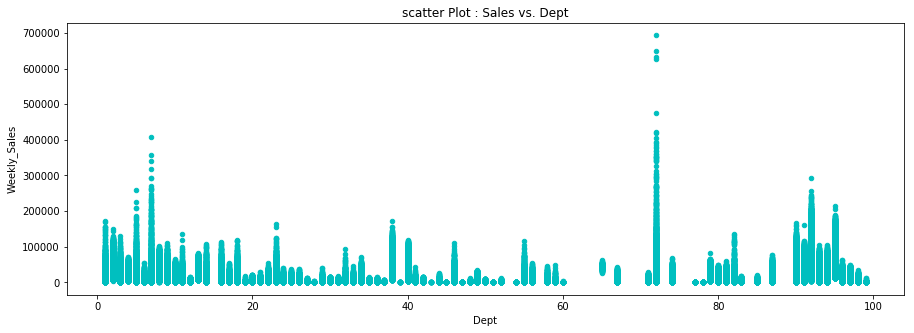

In [26]:
walmartdata.plot.scatter(x='Dept',y='Weekly_Sales',color ='c',title = 'scatter Plot : Sales vs. Dept',figsize = (15,5))

In [27]:
originaldata = walmartdata

In [28]:
#walmartdata.plot.scatter(x='IsHoliday',y='Weekly_Sales',color ='c',title = 'Scatter Plot : Sales vs. IsHoliday')

In [29]:
#coint_johansen(walmartdata,-1,1).eig

In [30]:
#Splitting the model as Train and Test split
#y=walmartdata.Weekly_Sales
#X_train, X_test, y_train, y_test = train_test_split(walmartdata, y, test_size=0.2)

In [31]:
def make_subset(df,store, dept):
    final_subset = df[df['Store']==store ]
    final_subset = final_subset[final_subset['Dept']==dept]
    return final_subset

In [32]:
data = make_subset(walmartdata,1,1)
print(data['Store'].unique())
print(data['Dept'].unique())

[1]
[1]


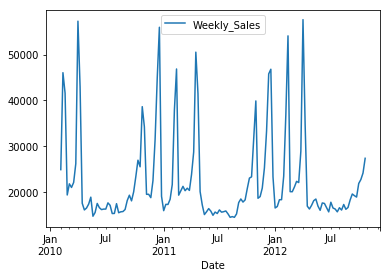

In [33]:
StoreSales = data[['Date','Weekly_Sales']].groupby('Date').sum()
StoreSales.plot()

In [34]:
data = data.set_index('Date')

In [35]:
#Split the data into Train and Test by sorting it using dates
walmartdata = data
#n = walmartdata.shape[0]
#train_size = 0.8

walmartdata = walmartdata.sort_values('Date')
#train_dataframe = walmartdata.iloc[:int(n * train_size)]
#test_dataframe = walmartdata.iloc[int(n * train_size):]
train_dataframe = walmartdata.loc[:'2012-02-29']
test_dataframe =  walmartdata.loc['2012-03-01':]

In [36]:
print(len(walmartdata))
print(len(train_dataframe))
print(len(test_dataframe))

143
108
35


In [37]:
print(test_dataframe)

            Store  Dept  Weekly_Sales    Size  IsHoliday_False  \
Date                                                             
2012-03-02      1     1      20113.03  151315                1   
2012-03-09      1     1      21140.07  151315                1   
2012-03-16      1     1      22366.88  151315                1   
2012-03-23      1     1      22107.70  151315                1   
2012-03-30      1     1      28952.86  151315                1   
2012-04-06      1     1      57592.12  151315                1   
2012-04-13      1     1      34684.21  151315                1   
2012-04-20      1     1      16976.19  151315                1   
2012-04-27      1     1      16347.60  151315                1   
2012-05-04      1     1      17147.44  151315                1   
2012-05-11      1     1      18164.20  151315                1   
2012-05-18      1     1      18517.79  151315                1   
2012-05-25      1     1      16963.55  151315                1   
2012-06-01

In [53]:
endog_train=train_dataframe[['Weekly_Sales']]
exog_train=train_dataframe[['Size','IsHoliday_False','IsHoliday_True']]

In [74]:
len(endog_train)
#exogarr=exog_train.to_xarray
type(exogarr)
exogarr =np.array(exog_train)
print(exogarr)

[[2.492450e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [4.603949e+04 1.513150e+05 0.000000e+00 1.000000e+00]
 [4.159555e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.940354e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [2.182790e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [2.104339e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [2.213664e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [2.622921e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [5.725843e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [4.296091e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.759696e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.614535e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.655511e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.741394e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.892674e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.477304e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.558043e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.755809e+04 1.513150e+05 1.000000e+00 0.000000e+00]
 [1.663762

In [95]:
#model = sm.tsa.statespace.SARIMAX(train_dataframe)
# fit model
model = sm.tsa.statespace.SARIMAX(endog_train,order = (1,1,1), seasonal_order = (0,0,0,52), enforce_invertibility=False).fit()
#model_fit = model.fit()
# one step forecast
prediction = model.predict(start=109, end=143)

C:\Users\shweta11714\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
C:\Users\shweta11714\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [ ]:
 #Perform Dickey-Fuller test: To check stationarity
    #print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(train_dataframe, autolag='AIC')
   # dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  #  for key,value in dftest[4].items():
     #   dfoutput['Critical Value (%s)'%key] = value
   # print (dfoutput)

In [ ]:
#coint_johansen(train_dataframe,-1,1).eig

In [96]:
#model = VAR(endog=train_dataframe)
#model_fit = model.fit()
# make prediction on validation
#prediction = model_fit.forecast(model_fit.y, steps=len(test_dataframe))
print(prediction)


2012-03-09    13941.925152
2012-03-16    13941.925152
2012-03-23    13941.925152
2012-03-30    13941.925152
2012-04-06    13941.925152
2012-04-13    13941.925152
2012-04-20    13941.925152
2012-04-27    13941.925152
2012-05-04    13941.925152
2012-05-11    13941.925152
2012-05-18    13941.925152
2012-05-25    13941.925152
2012-06-01    13941.925152
2012-06-08    13941.925152
2012-06-15    13941.925152
2012-06-22    13941.925152
2012-06-29    13941.925152
2012-07-06    13941.925152
2012-07-13    13941.925152
2012-07-20    13941.925152
2012-07-27    13941.925152
2012-08-03    13941.925152
2012-08-10    13941.925152
2012-08-17    13941.925152
2012-08-24    13941.925152
2012-08-31    13941.925152
2012-09-07    13941.925152
2012-09-14    13941.925152
2012-09-21    13941.925152
2012-09-28    13941.925152
2012-10-05    13941.925152
2012-10-12    13941.925152
2012-10-19    13941.925152
2012-10-26    13941.925152
2012-11-02    13941.925152
Freq: W-FRI, dtype: float64


In [ ]:
#converting predictions to dataframe
#cols = walmartdata.columns
#pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
#for j in range(0,8):
    #for i in range(0, len(prediction)):
       #pred.iloc[i][j] = prediction[i][j]

In [ ]:
#pred.info()
#predict = pred.drop('Type_C', axis=1)
#predict.head()

In [ ]:
#Type_C from test data
#validation = test_dataframe.drop('Type_C', axis=1)
#validation.head()

In [ ]:
print('VAR model RMSE:{} %.4f' % np.sqrt(mean_squared_error(predict,validation)))

In [ ]:
#check rmse
Finalcols = validation.columns
for i in Finalcols:
    print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(predict[i], validation[i])))

In [ ]:
predict.head()

In [ ]:
validation.reset_index(inplace = True)
validation.head()

In [ ]:
fig, axs = plt.subplots(ncols=1)
plt.plot(predict['Weekly_Sales'], color='blue')
#Validatedsales = validation[['Date','Weekly_Sales']].groupby('Date').sum()
#Validatedsales.plot()

Predictedsales = validation[['Date','Weekly_Sales']].groupby('Date').sum()
Predictedsales.plot()
plt.show()

In [ ]:
walmartdata.head()
index1 = [i for i in range(len(predict))]

walmartdata.head()

In [ ]:
test_dataframe.reset_index(inplace = True)
test_dataframe.head()

In [ ]:
predict.reset_index(inplace = True)
predict.head()

In [ ]:

predict.info()

In [ ]:
fig = plt.figure (figsize = (8,7))
#plt.plot(test_dataframe['Date'],test_dataframe['Weekly_Sales'] , 'r') # plotting t, a separately 
plt.plot(predict[['index']], predict[['Weekly_Sales']], 'b') # plotting t, b separately 
#plt.plot(t, c, 'g') # plotting t, c separately 
plt.show()

In [ ]:
predict.info()

In [ ]:
fig, axs = plt.subplots(ncols=2)
sns.regplot(x='value', y='wage', data=df_melt, ax=axs[0])
sns.regplot(x='value', y='wage', data=df_melt, ax=axs[1])
sns.boxplot(x='education',y='wage', data=df_melt, ax=axs[2])